To-do:

1. create single symmetrical co-occurrence matrix (with general semantic embeddings)
2. determine target/landmark pairings from this matrix 
3. visualize object clusters
4. compare clusters across language models
5. design room

In [1]:
from transformers import pipeline
import numpy as np
import pandas as pd
import gzip
import fastparquet
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from transformers import BertTokenizer, BertModel, TFBertForMaskedLM

In [2]:
# read conceptnet
conceptnet = pd.read_parquet('conceptnet_small.parquet.gzip',columns=['uri','relation','start_node','end_node','info'])

# choose room for which to search relations
room =  'kitchen'
cn_room = '/c/en/' + room
node = 'end_node'
object_relations = conceptnet[conceptnet[node] == cn_room]

# create list of objects typically associated with chosen room type
objs = []

for i in range(object_relations.shape[0]):
    objs.append(object_relations['start_node'].iloc[i][6:])

## object list pre-processing for use with bert (because bert would tokenize phrases into single words and sometimes words into syllables, i chose the following preprocessing steps)

# use second word in word pairing
objects = []

for i in range(len(objs)):
    tmp = str(objs[i]).split('_')
    objects.append(tmp[len(tmp)-1])
    

In [3]:
# get objects (see post_objects.xlsx for more preprocessing info)
all_objs = pd.read_excel('post_objects.xlsx')
landmarks = all_objs['landmark'].iloc[0:6]
objects = all_objs['target']

In [4]:
# load bert
mlm = "bert-base-uncased"
model = TFBertForMaskedLM.from_pretrained(mlm)
unmasker = pipeline('fill-mask', model = mlm)

# tokenize objects for bert
tokenizer = BertTokenizer.from_pretrained(mlm)

landmark = []

for i in range(len(landmarks)):
    new = tokenizer.tokenize(landmarks[i])
    
    if len(new[0]) == len(landmarks[i]):
        landmark.append(new[0])
        
target = []

for i in range(len(objects)):
    new = tokenizer.tokenize(objects[i])
    
    if len(new[0]) == len(objects[i]):
        target.append(new[0])


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
#find indeces of vocab list for targets and landmarks
inputs = tokenizer(landmark, return_tensors="np")
idx_landmark = []

for i in range(len(landmark)):
    idx_landmark.append(inputs.input_ids[i][1])
    
inputs = tokenizer(target, return_tensors="np")
idx_target = []

for i in range(len(target)):
    idx_target.append(inputs.input_ids[i][1])

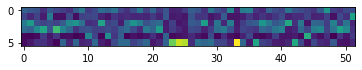

In [6]:
#find logits of [MASK] for all vocab words
cooccur_landmark = np.zeros((len(landmark),len(target)))

for i in range(len(landmark)):
    
    sentence = 'The [MASK] should be in the ' + room + ' on the ' + landmark[i] +  '.'

    inputs = tokenizer(sentence, return_tensors="tf")
    logits = model(**inputs).logits

    mask_token_index = tf.where((inputs.input_ids == tokenizer.mask_token_id)[0])
    selected_logits = tf.gather_nd(logits[0], indices=mask_token_index)

    cooccur_landmark[i,:] = selected_logits.numpy()[0,idx_target]

for i in range(len(target)):
        
    cooccur_landmark[:,i] = (tf.nn.softmax(cooccur_landmark[:,i])).numpy()

plt.imshow(cooccur_landmark)

In [7]:
# visualize landmark/target object pairs
best_landmark = []
for i in range(len(target)):
    idx = np.flip(np.argsort(cooccur_landmark[:,i]))
    best_landmark.append(landmark[idx[0]])
    
pair = pd.DataFrame(target, columns=['target'])
pair.insert(1,"landmark",best_landmark)

In [8]:
#create target/target cooccurrence matrix for each landmark   
cooccur_target = {} 

for i in range(len(landmark)):
    
    selected_targets = list(pair['target'][pair['landmark']==landmarks[i]])
    cooccur = np.zeros((len(selected_targets),len(selected_targets)))
    
    inputs = tokenizer(target, return_tensors="np")
    idx_selected_targets = []

    for x in range(len(selected_targets)):
        idx_selected_targets.append(inputs.input_ids[x][1])

    for j in range(len(selected_targets)):
    
        sentence = 'The [MASK] should be in the ' + room + ' next to the ' + selected_targets[j] + ' on the ' + landmark[i] + '.'

        inputs = tokenizer(sentence, return_tensors="tf")
        logits = model(**inputs).logits

        mask_token_index = tf.where((inputs.input_ids == tokenizer.mask_token_id)[0])
        selected_logits = tf.gather_nd(logits[0], indices=mask_token_index)

        cooccur[j,:] = tf.nn.softmax(selected_logits.numpy()[0,idx_selected_targets])


In [9]:
# landmark/target co-occurrence mat
cooccur = np.zeros((len(landmark),len(target)))

for i in range(len(landmark)):
    for j in range(len(target)):
        sentence = 'The [MASK] is on the ' + landmark[i] + ' in the ' + room + '.'
        result = unmasker(sentence, targets = target[j])
        cooccur[i,j] = result[0].get("score")

In [10]:
# target/target co-occurrence mat
cooccur = np.zeros((len(landmark),len(target)))

for i in range(len(landmark)):
    for j in range(len(target)):
        sentence = 'The [MASK] is on the ' + landmark[i] + ' in the ' + room + '.'
        result = unmasker(sentence, targets = target[j])
        cooccur[i,j] = result[0].get("score")
sentence = 'The [MASK] is next to the ' + target[0] + ' on the ' + landmark[0] + ' in the ' + room + '.'


In [11]:
num_targets = []

for i in range(len(landmarks)):
    num_targets.append(sum(pair.landmark == landmarks[i]))
    
print(num_targets)

[9, 2, 15, 13, 4, 9]


In [12]:
pair['target'][pair['landmark']==landmarks[5]]

11          crab
15           fan
23    ingredient
24          iron
25        kettle
27         maker
33           oil
36           pan
42           pot
Name: target, dtype: object

In [13]:
landmarks

0    counter
1      floor
2      table
3      shelf
4       wall
5      stove
Name: landmark, dtype: object